In [19]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [65]:
import os
import copy
import pickle

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import colors

from sklearn.datasets import make_classification

from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.externals import joblib
from sklearn.decomposition import PCA, FastICA

from time import perf_counter

import umap

from utilities import get_reconstruction_error, get_pca_components_for_var, df_to_heatmap, get_max_along_df_axis

In [21]:
# Import shared settings
from settings import random_state, n_jobs, nSamples, max_iter, test_size, class_sep
# Override settings
#...

In [22]:
# Used for plot names
dim_red_name = "pca"
casename = f"synthetic_{dim_red_name}"
# scoreText = "Score (Classification Accuracy)"

# Generate Data

In [98]:
X_full, y_full = make_classification(n_samples=nSamples, n_features=40, n_informative=10, n_redundant=5, n_classes=6, random_state=random_state, class_sep=class_sep)

X, X_test, y, y_test = train_test_split(X_full, y_full, test_size=test_size, 
                                      random_state=random_state, stratify=y_full)

print('')
print(f'X.shape = {X.shape}')
print(f'y.shape = {y.shape}')
print("Fraction of training data for each label = ")
for label in np.unique(y):
    print(f'\tData labelled {label} = {(y == label).sum() / float(len(y))}')

print('')
print(f'X_test.shape = {X_test.shape}')
print(f'y_test.shape = {y_test.shape}')
print("Fraction of testing data for each label = ")
for label in np.unique(y):
    print(f'\tData labelled {label} = {(y == label).sum() / float(len(y))}')


X.shape = (2000, 40)
y.shape = (2000,)
Fraction of training data for each label = 
	Data labelled 0 = 0.165
	Data labelled 1 = 0.169
	Data labelled 2 = 0.17
	Data labelled 3 = 0.1635
	Data labelled 4 = 0.166
	Data labelled 5 = 0.1665

X_test.shape = (500, 40)
y_test.shape = (500,)
Fraction of testing data for each label = 
	Data labelled 0 = 0.165
	Data labelled 1 = 0.169
	Data labelled 2 = 0.17
	Data labelled 3 = 0.1635
	Data labelled 4 = 0.166
	Data labelled 5 = 0.1665


# Apply initial PCA and pick key numbers of components

In [99]:
pipe_choose_components = Pipeline([('scaler', StandardScaler()), 
                                   ('pca', PCA(random_state=random_state))])
pipe_choose_components.fit(X)

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('pca', PCA(copy=True, iterated_power='auto', n_components=None, random_state=1,
  svd_solver='auto', tol=0.0, whiten=False))])

In [100]:
target_explained_var = (0.10, 0.25, 0.5, 0.75, 0.85, 0.9, 0.95, 0.9999)
# Artificially add in all components at the end
n_components_and_var = [get_pca_components_for_var(pipe_choose_components.named_steps['pca'], var) for var in target_explained_var] + [(X.shape[1], 1.0)]
if n_components_and_var[-1][0] == n_components_and_var[-2][0]:
    n_components_and_var.pop()
n_components = [x[0] for x in n_components_and_var]

In [101]:
print("n_components values to run:")

for nc, var in n_components_and_var:
    print(f'explained var = {var:.3f} --> n_components = {nc:3d} (components 0 through {nc})')

print("vector of n_components (easy copy/paste to other dimension reduction code)")
print(n_components)

n_components values to run:
explained var = 0.152 --> n_components =   2 (components 0 through 2)
explained var = 0.284 --> n_components =   5 (components 0 through 5)
explained var = 0.512 --> n_components =  13 (components 0 through 13)
explained var = 0.761 --> n_components =  23 (components 0 through 23)
explained var = 0.852 --> n_components =  27 (components 0 through 27)
explained var = 0.916 --> n_components =  30 (components 0 through 30)
explained var = 0.955 --> n_components =  32 (components 0 through 32)
explained var = 1.000 --> n_components =  35 (components 0 through 35)
explained var = 1.000 --> n_components =  40 (components 0 through 40)
vector of n_components (easy copy/paste to other dimension reduction code)
[2, 5, 13, 23, 27, 30, 32, 35, 40]


In [102]:
# n_components = [2, 3, 4, 5, 7, 10, 13, 15, 20, 25, 30, 35, 40]
reconstruction_error = np.zeros(len(n_components))
for i, this_n in enumerate(n_components):
    pipe_reconstruction = Pipeline([('scaler', StandardScaler()), 
                                       ('pca', PCA(random_state=random_state, n_components=this_n))])
    pipe_reconstruction.fit(X)
    reconstruction_error[i] = get_reconstruction_error(X, pipe_reconstruction)

In [119]:
joblib.dump(np.array((n_components, reconstruction_error)).T, f'{casename}_reconstruction_error.pkl')

['synthetic_pca_reconstruction_error.pkl']

array([[2.00000000e+00, 2.88037867e+00],
       [5.00000000e+00, 1.41081552e+00],
       [1.30000000e+01, 1.02001080e+00],
       [2.30000000e+01, 6.69840507e-01],
       [2.70000000e+01, 5.39123622e-01],
       [3.00000000e+01, 4.13395023e-01],
       [3.20000000e+01, 3.43300237e-01],
       [3.50000000e+01, 1.21079001e-29],
       [4.00000000e+01, 1.19491598e-29]])

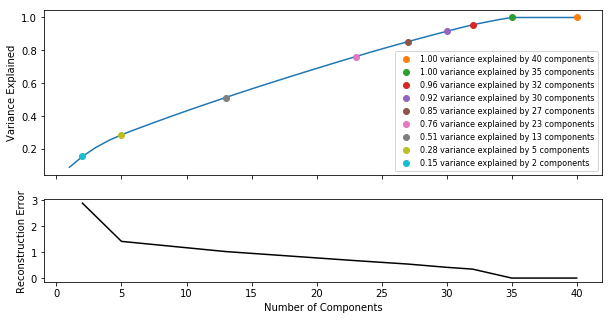

In [105]:
fig, ax = plt.subplots(nrows=2, figsize=(10, 5), sharex=True, gridspec_kw={'height_ratios': [2, 1]})

evrc = pipe_choose_components.named_steps['pca'].explained_variance_ratio_.cumsum()
ax[0].plot(range(1, len(evrc) + 1), evrc)
to_plot = n_components_and_var.copy()
to_plot.reverse()
for i, var in to_plot:
    ax[0].plot(i, evrc[i-1], 'o', label=f'{var:.2f} variance explained by {i} components')
ax[0].legend(fontsize=8)
ax[0].set_ylabel("Variance Explained")
ax[1].plot(n_components, reconstruction_error, 'k', label='Reconstruction Error')
ax[1].set_xlabel("Number of Components")
ax[1].set_ylabel("Reconstruction Error")

fig.savefig(f'{casename}_variance_reconstruction.png')

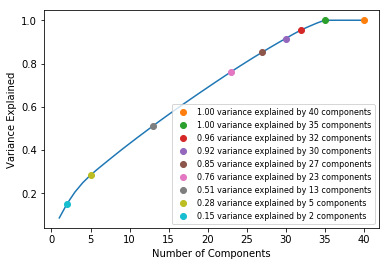

In [109]:
fig, ax = plt.subplots()
evrc = pipe_choose_components.named_steps['pca'].explained_variance_ratio_.cumsum()
ax.plot(range(1, len(evrc) + 1), evrc)
to_plot = n_components_and_var.copy()
to_plot.reverse()
for i, var in to_plot:
    ax.plot(i, evrc[i-1], 'o', label=f'{var:.2f} variance explained by {i} components')
ax.set_ylabel("Variance Explained")
ax.set_xlabel("Number of Components")
ax.legend(fontsize=8)
fig.savefig(f'{casename}_variance.png')

In [45]:
# OVERRIDE n_components
n_components = [2, 3, 4, 5, 13, 23, 27, 30, 32, 35, 40]

# Run MLP using results of PCA through Grid Search

In [46]:
pipe = Pipeline([('scaler', StandardScaler()),
                  ('pca', PCA(random_state=random_state)),
                  ('mlp', MLPClassifier(max_iter=max_iter, random_state=random_state))])

#                  [0.5, 0.75, 0.9, 0.95, 0.99]
hidden_layer_sizes = [(2, ), (6, ), (10, ), (15, )]
param_grid = {'pca__n_components': n_components,
             'mlp__hidden_layer_sizes': hidden_layer_sizes,
             }
gs = GridSearchCV(pipe, param_grid=param_grid, verbose=10, cv=3, return_train_score=True, 
                  n_jobs=n_jobs)

In [47]:
gs.fit(X, y)

Fitting 3 folds for each of 44 candidates, totalling 132 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   12.4s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   16.0s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   21.1s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   29.6s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   38.2s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   49.6s
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 132 out of 132 | elapsed:  2.1min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('pca', PCA(copy=True, iterated_power='auto', n_components=None, random_state=1,
  svd_solver='auto', tol=0.0, whiten=False)), ('mlp', MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       bet...=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'pca__n_components': [2, 3, 4, 5, 13, 23, 27, 30, 32, 35, 40], 'mlp__hidden_layer_sizes': [(2,), (6,), (10,), (15,)]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=10)

In [48]:
joblib.dump(gs, casename + "_gs.pkl")

['synthetic_pca_gs.pkl']

In [49]:
gs.best_estimator_

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('pca', PCA(copy=True, iterated_power='auto', n_components=35, random_state=1,
  svd_solver='auto', tol=0.0, whiten=False)), ('mlp', MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_...=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False))])

In [50]:
results = pd.DataFrame(gs.cv_results_)
results.to_csv(casename + "_results.csv")

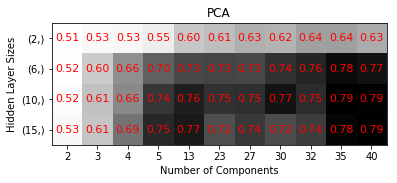

In [110]:
x_variable = "param_pca__n_components"
y_variable = "param_mlp__hidden_layer_sizes"
z_variable = "mean_test_score"

df_to_heatmap(results, x_variable, y_variable, z_variable, fontsize=11, title='PCA', xlabel='Number of Components', ylabel='Hidden Layer Sizes', savefig=f'{casename}_gs.png')

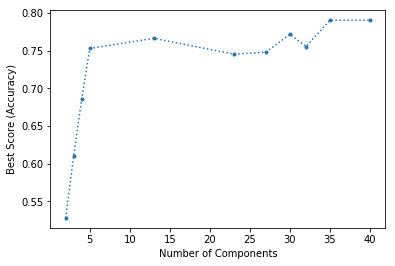

In [111]:
x_variable = "param_pca__n_components"
z_variable = "mean_test_score"
best_scores = get_max_along_df_axis(results, z_variable, x_variable)
fig, ax = plt.subplots()
ax.plot(best_scores[:, 0], best_scores[:, 1], '.:', label='MLP fit on PCA')
ax.set_xlabel("Number of Components")
ax.set_ylabel("Best Score (Accuracy)")
plt.show()

# Visualize the data

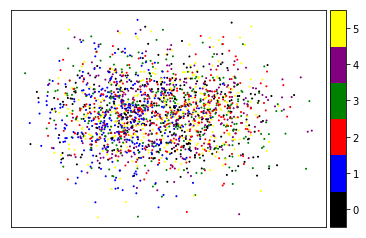

In [85]:
fig, ax = plt.subplots()

# make a color map of fixed colors
cmap = colors.ListedColormap(['black', 'blue', 'red', 'green', 'purple', 'yellow'])
bounds = np.linspace(y.min() - 0.5, y.max() + 0.5, len(np.unique(y)) + 1)
norm = colors.BoundaryNorm(bounds, cmap.N)

sc = ax.scatter(X[:, 0], X[:, 1], c=y, s=1, cmap=cmap, norm=norm)

ax.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    left=False,
    right=False,
    labelleft=False,
    labelbottom=False) # labels along the bottom edge are off

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
ax.get_figure().colorbar(sc, cax=cax, ticks=[0, 1, 2, 3, 4, 5])

fig.savefig('synthetic_vis_base.png')

In [55]:
visualization_pipe = Pipeline([('scaler', StandardScaler()),
                               ('pca', PCA(n_components=2, random_state=random_state))])
X_vis = visualization_pipe.fit_transform(X)                       

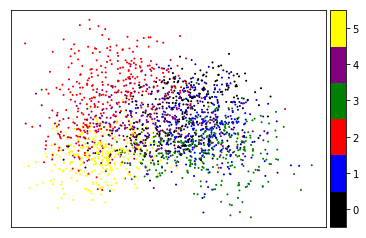

In [120]:
fig, ax = plt.subplots()

# make a color map of fixed colors
cmap = colors.ListedColormap(['black', 'blue', 'red', 'green', 'purple', 'yellow'])
bounds = np.linspace(y.min() - 0.5, y.max() + 0.5, len(np.unique(y)) + 1)
norm = colors.BoundaryNorm(bounds, cmap.N)

sc = ax.scatter(X_vis[:, 0], X_vis[:, 1], c=y, s=1, cmap=cmap, norm=norm)

ax.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    left=False,
    right=False,
    labelleft=False,
    labelbottom=False) # labels along the bottom edge are off

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
ax.get_figure().colorbar(sc, cax=cax, ticks=[0, 1, 2, 3, 4, 5])

fig.savefig('synthetic_vis_pca.png')